<a href="https://colab.research.google.com/github/btroib/Final_DS_Project/blob/master/CheckPoint3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Intro

** Team Number One ** 

In [1]:
!git clone https://github.com/btroib/Final_DS_Project.git

Cloning into 'Final_DS_Project'...
remote: Enumerating objects: 5654, done.
remote: Counting objects: 100% (5654/5654), done.
remote: Compressing objects: 100% (5326/5326), done.
remote: Total 5654 (delta 359), reused 5600 (delta 326), pack-reused 0
Receiving objects: 100% (5654/5654), 92.49 MiB | 38.93 MiB/s, done.
Resolving deltas: 100% (359/359), done.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 0.1 Project description and status

### Project description


### Technical project description
#### Data available
CT scans from patients with or without intracranial hemorrhage.
- 82 patients in total
- 36 patients with intracranial hemorrhage / 46 normal patients
- 30.5 CT slices on average for each patient
- 46 males / 36 females

#### Methodology
- We performed Data augmentation by using the images and making a 90° rotation to them, because the dataset was unbalanced and also in order to reduce overfitting.
- We resized images and masks to 224x224 to reduce features high dimensionality
- We split the remainder of the data into 80% train and 20% validation.
- We used multiple models to classify the images: SGD, CNN
- We used shap for interpretability analysis and noticed some parts of the extremities of the image were weighted strongly by the model when they should not. We will add preprocessing to the image to suppress this issue.

### Achievements

ACCURACY levels achieved:  
- Model baseline: 51.9% (representation of hemorrage in our post-data augmentation dataset)
- SGD: 59%. 
- CNN: 84.9%

Until now, our best performing model was a Convolutional Neural Network trained on a 20% test set size and a 20% validation set size.


## 0.2 Technical description of the project

Describe the dataset(s) you used, steps you took to analyze and preprocess the data, and different models you tried. It should include a comparison of your baseline model with other models that you have tried.


## 0.3 Challenges
1) The fact the dataset was unbalanced first gave us results with very high accuracies (90%) but with a dataset having a 82% baseline. We therefore decided to do Data augmentation in order to artifically balance our dataset.  
2) Results interpretability is difficult because we use deep learning algorithms, but Shap helped us visualise which pixels were considered important by the algorithm. We did not expect some parts of the images, where there is most of the time no head (so the pixel should not have been relevant) was taken into account by the algorithm during the training.\
3) \


## 0.4 Remaining steps

- find and implement new models aiming at increasing overall prediction performance
- improve current models by adding a dropout or by increasing the image sizes
- from Shap we identified that the model takes into account a white strip away from the head; we think it is medical equipment and we might remove it and see if performance improves
- preparation of a medium article
- preparation of a ppt presentation

### Work split
- Brian Troib: preparation of the medium article, improve current models
- Dan Oren: remove image issue, improve current models
- Michael Ben Mergui: find and implement new models aiming at increasing overall prediction performance, remove image issue
- Roy Fassler: preparation of a powerpoint presentation

# 1. EDA

In [3]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from matplotlib.pyplot import imread

In [4]:
def check_missing(dataframe):
    if len(dataframe.columns[dataframe.isnull().any()]) == 0:
        print('There are no missing values.')
    else:
        print('Column Name', ' ', 'Number of Missing Values', ' ', 'Percentage of Total')
        for index, value in dataframe.isnull().sum().items():
            if value>0:
                print(index, ' '*(23-len(index)), value, ' '*(18-len(str(value))),'  ', 
                      round(value*100/len(dataframe), 2), "%")
                
def check_eda(dataframe):
    print('Preview of data: ')
    display(dataframe.head(3))
    print('\n', '-'*50, '\n')
    find_shape(dataframe)
    print('\n', '-'*50)
    print('\n Total number of rows, column types and null values:\n')
    print(dataframe.info())
    
def find_shape(dataframe):
    print('Rows:', dataframe.shape[0])
    print('Columns:', dataframe.shape[1])
    
def check_integrity(dataframe):
    print('Checking for duplicated rows...')
    print('\nNumber of duplicated rows: ', dataframe[dataframe.duplicated()].shape[0])
    if (dataframe[dataframe.duplicated()].shape[0]) > 0:
        print('\nDropping duplicates...')
        dataframe.drop_duplicates(inplace=True)
        print('\nDropped.')
    print('\nChecking min, max, mean and STD of numerical features to see if any values are illogical.')
    display(dataframe.describe(include='all').transpose())
    print('\nCounting the unique values of non numerical features (including missing values):\n')
    for col in dataframe.select_dtypes(include='object').columns:
        print('Count of: ', col)
        print(dataframe[col].value_counts(dropna=False), '\n')

We will start with reading the files hemorrhage_diagnosis.csv and patient_demographics.csv. The first file contains the labels (hemorrhage type, fracture) for each slice and for each patient and the second file contains information related to the patient such as patient age and gender.

In [5]:
df_hemorrhage = pd.read_csv('Final_DS_Project/hemorrhage_diagnosis.csv')
df_patient = pd.read_csv('Final_DS_Project/patient_demographics.csv')

We'll take a look at the header of the dataframes to check that all the names of the columns and the values are aligned.

In [6]:
df_hemorrhage.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [7]:
df_patient.head()

,Patient Number,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note
0,49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN
1,50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN
2,51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN
3,52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN
4,53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN


It is also necessary to know the dimensions of the data.

In [8]:
rows, columns = df_hemorrhage.shape
print(f"The dataset hemorrhage contains {rows} rows and {columns} columns")
rows, columns = df_patient.shape
print(f"The dataset patient contains {rows} rows and {columns} columns")

The dataset hemorrhage contains 2501 rows and 9 columns
The dataset patient contains 82 rows and 11 columns


In [9]:
assert df_patient["Patient Number"].is_unique

In [10]:
df_hemorrhage.groupby("PatientNumber").size().mean()

30.5

We can see that the data set contains the information of 82 patients and of each one we have the information of certain demographics such as age and gender. Also, in the hemorrhage diagnosis dataset we can see that on average each patient has 30.5 thomography slices. 

Next we are going to load the thomography slices.

In [11]:
IMAGES_DIRECTORY = 'Final_DS_Project/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT'
patient = {}
for paitent_folder in os.listdir(IMAGES_DIRECTORY):
    patient_brain_folder = IMAGES_DIRECTORY+"/"+paitent_folder+"/brain"
    for image_name in os.listdir(patient_brain_folder):
        if len(image_name[:-4]) > 2 :
          continue
        img = cv2.imread(patient_brain_folder+"/"+image_name, cv2.IMREAD_GRAYSCALE).flatten()
        patient[f'{paitent_folder}-{image_name[:-4]}'] = img



Next we are going to transform the dictionary patient to a dataframe df_brain.

In [12]:
df_brain = pd.DataFrame(patient)
df_brain = df_brain.transpose()

In [13]:
df_brain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,422460,422461,422462,422463,422464,422465,422466,422467,422468,422469,422470,422471,422472,422473,422474,422475,422476,422477,422478,422479,422480,422481,422482,422483,422484,422485,422486,422487,422488,422489,422490,422491,422492,422493,422494,422495,422496,422497,422498,422499
064-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
064-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
064-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
064-8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
064-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df_brain.shape

(2501, 422500)

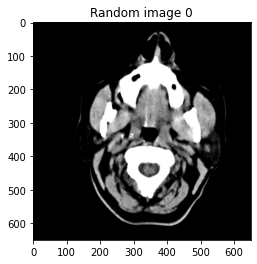

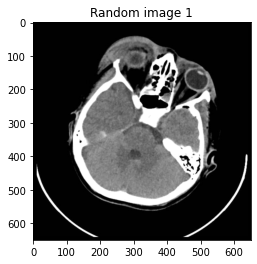

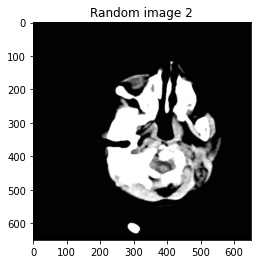

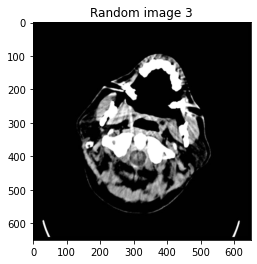

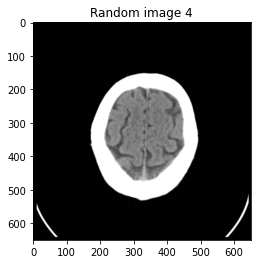

In [15]:
for index in range(5):
  random_image = df_brain.sample().to_numpy().reshape(650,-1)
  plt.title(f'Random image {index}')
  plt.imshow(random_image, cmap='gray');
  plt.show();

We can see that the index of our dataframe represents the indetifier of the patient and image and the columns represent each pixel of the image. The size of the images is 650x650 pixels, so it makes sense that we have 422,500 columns

$ 650^2 = 422500 $

#### General summary statistics

Let's start by analyzing df_patient

In [16]:
df_patient.describe()

,Patient Number,Age\n(years),Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No)
count,82.000000,82.000000,5.0,16.0,7.0,21.0,4.0,22.0
mean,89.500000,27.843733,1.0,1.0,1.0,1.0,1.0,1.0
std,23.815261,19.520890,0.0,0.0,0.0,0.0,0.0,0.0
min,49.000000,0.002747,1.0,1.0,1.0,1.0,1.0,1.0
25%,69.250000,11.250000,1.0,1.0,1.0,1.0,1.0,1.0
50%,89.500000,26.000000,1.0,1.0,1.0,1.0,1.0,1.0
75%,109.750000,40.000000,1.0,1.0,1.0,1.0,1.0,1.0
max,130.000000,72.000000,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient Number     82 non-null     int64  
 1   Age
(years)        82 non-null     float64
 2   Gender             82 non-null     object 
 3   Intraventricular   5 non-null      float64
 4   Intraparenchymal   16 non-null     float64
 5   Subarachnoid       7 non-null      float64
 6   Epidural           21 non-null     float64
 7   Subdural           4 non-null      float64
 8   Fracture (Yes/No)  22 non-null     float64
 9   Condition on file  82 non-null     object 
 10  Note               1 non-null      object 
dtypes: float64(7), int64(1), object(3)
memory usage: 7.2+ KB


In [18]:
df_patient.describe(include=['O'])

,Gender,Condition on file,Note
count,82,82,1
unique,2,13,1
top,Male,Normal CT,"Special case, CT scan was after about two week..."
freq,46,47,1


Observations:

* The average age of the sample is 28 years, and covers a range from 0 to 72 years.
* The gender of the sample is balanced: 46 Male and 36 Female.
* 57% of the sample has a Normal CT.

We can see that when the patient does not present any condition of: Intraventricular, Intraparenchymal, Subarachnoid, Epidural, Subdural or Fracture (Yes / No), it is marked as Nan. A good option is to fillna these columns with the value 0. Also, only one patient has a comment in the Note column.

Let's continue with the dataframe df_hemorrhage

In [19]:
df_hemorrhage.describe()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000
mean,89.591363,15.909636,0.009596,0.029188,0.007197,0.069172,0.022391,0.872851,0.077969
std,23.762360,9.071176,0.097508,0.168368,0.084547,0.253798,0.147981,0.333207,0.268176
min,49.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,90.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,110.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,130.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df_hemorrhage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   PatientNumber     2501 non-null   int64
 1   SliceNumber       2501 non-null   int64
 2   Intraventricular  2501 non-null   int64
 3   Intraparenchymal  2501 non-null   int64
 4   Subarachnoid      2501 non-null   int64
 5   Epidural          2501 non-null   int64
 6   Subdural          2501 non-null   int64
 7   No_Hemorrhage     2501 non-null   int64
 8   Fracture_Yes_No   2501 non-null   int64
dtypes: int64(9)
memory usage: 176.0 KB


Observations:

* 87% of patients are No_Hemorrhage.
* The most common hemorrhage is Epidural (6%), followed by Intraparenchymal (2.9%).

We can see that in this dataset it has no missing values.

As we saw previously, the df_patient dataframe has several columns with missing values, below we can observe the% of null values in each one.

In [21]:
check_missing(df_patient)

Column Name   Number of Missing Values   Percentage of Total
Intraventricular         77                     93.9 %
Intraparenchymal         66                     80.49 %
Subarachnoid             75                     91.46 %
Epidural                 61                     74.39 %
Subdural                 78                     95.12 %
Fracture (Yes/No)        60                     73.17 %
Note                     81                     98.78 %


#### Some interesting plots

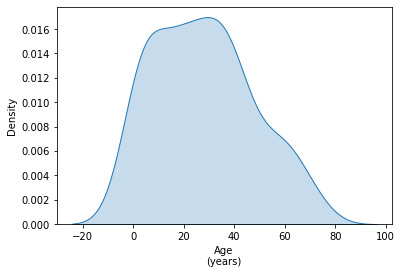

In [22]:
sns.kdeplot(data=df_patient, x="Age\n(years)", shade=True);

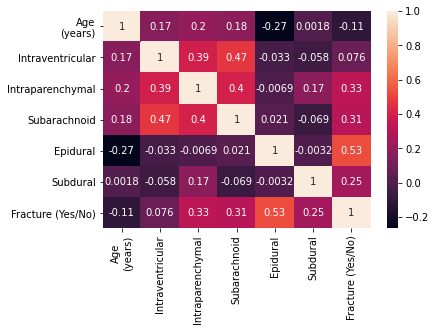

In [23]:
sns.heatmap(df_patient.drop("Patient Number",axis=1).fillna(0).corr(), annot=True);

# 2. Model baseline building

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, \
                            precision_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

## Splitting the Hemorrage_diagnosic dataset

We have decided to first focus on predicting, based on our Hemorrage dataset, if the patients have (or not) a brain hemorrhage.  
This is a **Classification** problem we are adressing.

- Target (to predict): 'No_Hemorrhage'.
- Features: our brain CT scans from all patients.  

We will start by splitting the dataset in a Train (80%). and test sets (20%).

In [25]:
X = df_brain
y = df_hemorrhage['No_Hemorrhage']

#Data Augmentaion

In [26]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [27]:
# creating folders
!mkdir train
!mkdir train/0 train/1
!mkdir test
!mkdir test/0 test/1

In [28]:
#Saving images in 2 folders according to type for data augmentation
for index in range(y.shape[0]):
  if y[index] == 0:
    new_img = X.iloc[index].to_numpy().reshape(650,-1)
    cv2.imwrite(f"train/{y[index]}/{index}.jpg", new_img)
  else:
    new_img = X.iloc[index].to_numpy().reshape(650,-1)
    cv2.imwrite(f"train/{y[index]}/{index}.jpg", new_img)
    

In [29]:
train_path_0 = r'train/0'
train_path_1 = r'train/1'
test_path_0 = r'test/0'
test_path_1 = r'test/1'

In [30]:
print(f"Class 0 before aug: {len(os.listdir(train_path_0))}")
print(f"Class 1 before aug: {len(os.listdir(train_path_1))}")
CLASS_0_SIZE = 318
CLASS_1_SIZE = 2183
CLASS_FULL_SIZE = CLASS_0_SIZE + CLASS_1_SIZE

Class 0 before aug: 318
Class 1 before aug: 2183


In [31]:
def image_aug(dir_aug_path, number_of_aug):
  datagen = ImageDataGenerator(rotation_range=90)
  for f in os.listdir(dir_aug_path):
    img = load_img(dir_aug_path + '/' + f)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                              save_to_dir = dir_aug_path,  
                              save_prefix ='aug', save_format ='jpg'):
        i += 1
        if i > number_of_aug-1: 
            break

In [32]:
import random
size_of_test_0 = round(len(os.listdir(train_path_0))*0.2)
size_of_train_0 = len(os.listdir(train_path_0)) - size_of_test_0
test_list_0 = random.sample(os.listdir(train_path_0),size_of_test_0)
size_of_test_1 = round(len(os.listdir(train_path_1))*0.2)
size_of_train_1 = len(os.listdir(train_path_1)) - size_of_test_1
test_list_1 = random.sample(os.listdir(train_path_1),size_of_test_1)
size_of_images = size_of_train_0 + size_of_test_0 + size_of_train_1 + size_of_test_1
for file_name in test_list_0:
  os.rename('train/0/' + file_name, 'test/0/' + file_name)
for file_name in test_list_1:
  os.rename('train/1/' + file_name, 'test/1/' + file_name)

In [33]:
if (size_of_images) <= CLASS_FULL_SIZE:
  if len(os.listdir(train_path_0)) == size_of_train_0:
    image_aug(train_path_0,20)
  if len(os.listdir(test_path_0)) == size_of_test_0:
    image_aug(test_path_0,20)
  if len(os.listdir(train_path_1)) == size_of_train_1:
    image_aug(train_path_1,2)
  if len(os.listdir(test_path_1)) == size_of_test_1:
    image_aug(test_path_1,2)

print(f"Train 0 after aug: {len(os.listdir(train_path_0))}")
print(f"Train 1 after aug: {len(os.listdir(train_path_1))}")
print(f"Test 0 after aug: {len(os.listdir(test_path_0))}")
print(f"Test 1 after aug: {len(os.listdir(test_path_1))}")

Train 0 after aug: 4194
Train 1 after aug: 4678
Test 0 after aug: 1263
Test 1 after aug: 1271


#Baseline - After Data Augmentation of images

In [34]:
AUGM_0_SIZE = len(os.listdir(train_path_0)) + len(os.listdir(test_path_0))
AUGM_1_SIZE = len(os.listdir(train_path_1)) + len(os.listdir(test_path_1))
TOTAL = AUGM_0_SIZE + AUGM_1_SIZE
print(TOTAL)
print(f'Model Baseline :{AUGM_1_SIZE / TOTAL}')

11406
Model Baseline :0.5215675960021041


#Creating datasets

In [35]:
img_gen = ImageDataGenerator(validation_split=0.2)

In [36]:
train_data = img_gen.flow_from_directory('train/', 
                                         class_mode= 'binary', 
                                         batch_size= 64, 
                                         target_size=(224, 224), 
                                         subset= 'training',
                                         color_mode= 'grayscale',shuffle=True)

Found 7099 images belonging to 2 classes.


In [37]:
valid_data = img_gen.flow_from_directory('train/', 
                                         class_mode= 'binary', 
                                         batch_size= 64, 
                                         target_size=(224, 224), 
                                         subset= 'validation',
                                         color_mode= 'grayscale',shuffle=True)

Found 1773 images belonging to 2 classes.


In [38]:
test_data = img_gen.flow_from_directory(directory=r"./test/", 
                                        class_mode= 'binary', 
                                        batch_size=64, 
                                        target_size=(224, 224), 
                                        color_mode= 'grayscale',shuffle=True)

Found 2534 images belonging to 2 classes.


# SGD

In [39]:
from sklearn.linear_model import SGDClassifier

In [40]:
sgdc = SGDClassifier(max_iter=1, tol=0.01, loss="log")
b=0

In [41]:
PIXEL_SIZE_224 = 50176

In [42]:
for index in range(len(train_data)):
  batch, labels = train_data.next()
  if batch.reshape(64,-1).shape[1] == PIXEL_SIZE_224 :
    sgdc.partial_fit(batch.reshape(64,-1), labels, classes=np.unique(train_data.classes))


In [43]:
y_true = []
y_pred = []
for index in range(len(test_data)):
  batch, labels = test_data.next()
  if batch.reshape(64,-1).shape[1] == PIXEL_SIZE_224 :
    y_true.append(labels)
    y_pred.append(sgdc.predict(batch.reshape(64,-1)))
                 

In [44]:
y_pred_SGD = np.concatenate(y_pred)
y_true_SGD = np.concatenate(y_true)

In [45]:
print(classification_report(y_true_SGD, y_pred_SGD))

              precision    recall  f1-score   support

         0.0       0.59      0.16      0.25      1250
         1.0       0.51      0.89      0.65      1246

    accuracy                           0.52      2496
   macro avg       0.55      0.52      0.45      2496
weighted avg       0.55      0.52      0.45      2496



# CNN

In [46]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
inp = Rescaling(1/255, input_shape=(224,224,1))
conv_layer = Conv2D(64, 3, activation='relu')
conv_layer2 = Conv2D(64, 3, activation='relu')
conv_layer3 = Conv2D(64, 3, activation='relu')
pool_layer = MaxPool2D()
pool_layer2 = MaxPool2D()
pool_layer3 = MaxPool2D()
flat_layer = Flatten()
dense_layer = Dense(64, activation='relu')
last_layer = Dense(1, activation='sigmoid')
model = Sequential([inp, conv_layer, pool_layer, conv_layer2, pool_layer2, 
                    conv_layer3, pool_layer3, flat_layer, dense_layer, last_layer])

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [49]:
history = model.fit(train_data, epochs=200, steps_per_epoch=len(train_data), 
                    validation_data=valid_data, 
                    validation_steps=len(valid_data), callbacks=[callback])

Epoch 1/200
111/111 [==============================] - 80s 425ms/step - loss: 0.6500 - accuracy: 0.5944 - val_loss: 0.5561 - val_accuracy: 0.7157
Epoch 2/200
111/111 [==============================] - 45s 406ms/step - loss: 0.5659 - accuracy: 0.6933 - val_loss: 0.5367 - val_accuracy: 0.7265
Epoch 3/200
111/111 [==============================] - 45s 408ms/step - loss: 0.4376 - accuracy: 0.7919 - val_loss: 0.6401 - val_accuracy: 0.7451


In [50]:
#To get prediction
pred = model.predict(test_data)

In [51]:
# to get the classes
test_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# ResNet50

In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [53]:
train_data2 = img_gen.flow_from_directory('train/', class_mode= 'binary', batch_size= 64, target_size=(224, 224), 
                                         subset= 'training', shuffle=True)
valid_data2 = img_gen.flow_from_directory('train/', class_mode= 'binary', batch_size= 64, 
                                         target_size=(224, 224), subset= 'validation')

Found 7099 images belonging to 2 classes.
Found 1773 images belonging to 2 classes.


In [54]:
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(1, activation="sigmoid")(head_model)

model_resnet = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
	layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [55]:
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
history_resnet = model_resnet.fit(train_data2, epochs=10, steps_per_epoch=len(train_data2), validation_data=valid_data2, validation_steps=len(valid_data2))

Epoch 1/10
111/111 [==============================] - 56s 467ms/step - loss: 0.7102 - accuracy: 0.5811 - val_loss: 0.5715 - val_accuracy: 0.7507
Epoch 2/10
111/111 [==============================] - 49s 439ms/step - loss: 0.6449 - accuracy: 0.6216 - val_loss: 0.5618 - val_accuracy: 0.7609
Epoch 3/10
111/111 [==============================] - 47s 427ms/step - loss: 0.6209 - accuracy: 0.6416 - val_loss: 0.5812 - val_accuracy: 0.6757
Epoch 4/10
111/111 [==============================] - 48s 430ms/step - loss: 0.5960 - accuracy: 0.6745 - val_loss: 0.4905 - val_accuracy: 0.8015
Epoch 5/10
111/111 [==============================] - 47s 426ms/step - loss: 0.5813 - accuracy: 0.6881 - val_loss: 0.5286 - val_accuracy: 0.7558
Epoch 6/10
111/111 [==============================] - 48s 428ms/step - loss: 0.5698 - accuracy: 0.6963 - val_loss: 0.5061 - val_accuracy: 0.8020
Epoch 7/10
111/111 [==============================] - 48s 431ms/step - loss: 0.5539 - accuracy: 0.7095 - val_loss: 0.5389 - val_ac

Found 2534 images belonging to 2 classes.


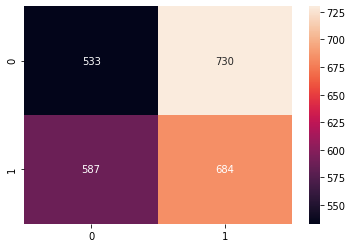

In [56]:
test_data2 = img_gen.flow_from_directory(directory=r"./test/",  class_mode= 'binary', batch_size=64, 
                                        target_size=(224, 224), shuffle=True)
preds_resnet = model_resnet.predict(test_data2)

preds_resnet = [1 if pred > 0.5 else 0 for pred in preds_resnet]
sns.heatmap(confusion_matrix(test_data2.classes, preds_resnet), annot=True, fmt='g')

# Shap

In [57]:
pip install shap

     |████████████████████████████████| 358kB 34.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=5ed973f31338773ec0f416a74eb255e275c70adf6794eec0e57ab1797febbd79
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [58]:
import shap
shap.initjs()
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

In [59]:
len(test_data)

40

In [60]:
batch_index = random.randint(0, len(test_data))
batch = train_data.next()
images, _ = batch
background = images[:20]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_data[batch_index][0][1:5])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


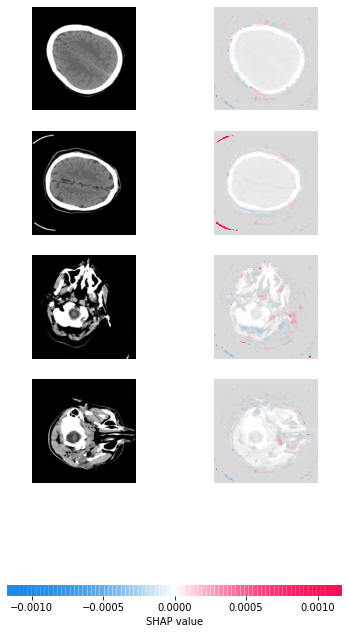

None

In [61]:
shap_plot = shap.image_plot(shap_values, test_data[batch_index][0][1:5]);
display(shap_plot);

# 3. Next steps

### Comments

### Main next steps

#### A) Build a model to detect intracranial hemorrhages. (0/1)

- Deal with very high dimensionality of our dataframes (>40 000 features due to image pixelisation). Options: image resizing, dimensionality reduction methods (e.g. PCA)
- Apply other classification ML models on the Hemorrhage classification.
- Apply deeplearning (e.g. CNN) with an optimized set of hyperparameters to process the images and increase model performance.
- Join and use data from the "demographics.csv" file to feed our model.


#### B) Build a model to segment hemorrhages per type

Hemorrhages exist in different types: Intraventricular, Intraparenchymal, Subarachnoid, Epidural and Subdural.  
- Build a model to try to classify in the right category. Multi-label classification problem.

### Possible extra next steps: 

- Build an API to automate the diagnosis of intracranial hemorrhages by providing the API pictures and receiving back the classification (single or multi-label).
- Build a model to identify a brain fracture from a CT scan.